## 기본 모델링

###MLP

Epoch [1/20], Loss: 0.7109, 학습 정확도: 67.00%, 평가 정확도: 69.41%
Epoch [2/20], Loss: 0.6708, 학습 정확도: 69.49%, 평가 정확도: 70.22%
Epoch [3/20], Loss: 0.6612, 학습 정확도: 69.91%, 평가 정확도: 70.13%
Epoch [4/20], Loss: 0.6550, 학습 정확도: 69.96%, 평가 정확도: 70.59%
Epoch [5/20], Loss: 0.6499, 학습 정확도: 70.34%, 평가 정확도: 70.53%
Epoch [6/20], Loss: 0.6428, 학습 정확도: 70.71%, 평가 정확도: 70.72%
Epoch [7/20], Loss: 0.6401, 학습 정확도: 70.74%, 평가 정확도: 70.64%
Epoch [8/20], Loss: 0.6392, 학습 정확도: 70.82%, 평가 정확도: 70.61%
Epoch [9/20], Loss: 0.6385, 학습 정확도: 70.93%, 평가 정확도: 70.73%
Epoch [10/20], Loss: 0.6365, 학습 정확도: 70.89%, 평가 정확도: 70.64%
Epoch [11/20], Loss: 0.6367, 학습 정확도: 71.00%, 평가 정확도: 70.66%
Epoch [12/20], Loss: 0.6358, 학습 정확도: 71.00%, 평가 정확도: 70.69%
Early stopping!


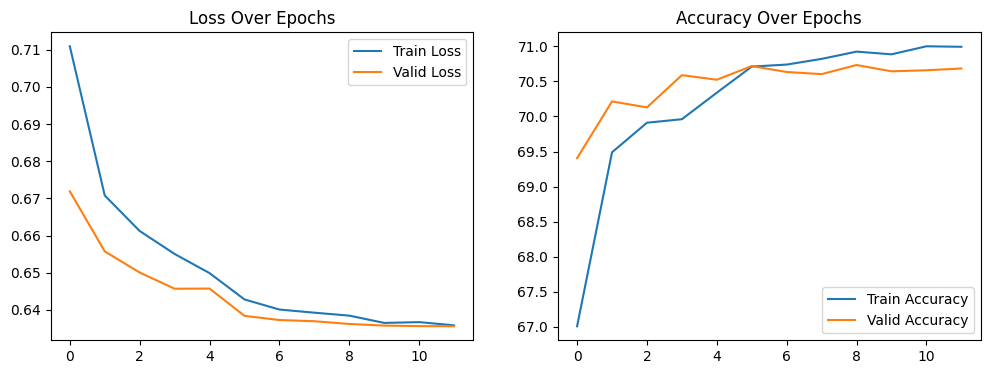

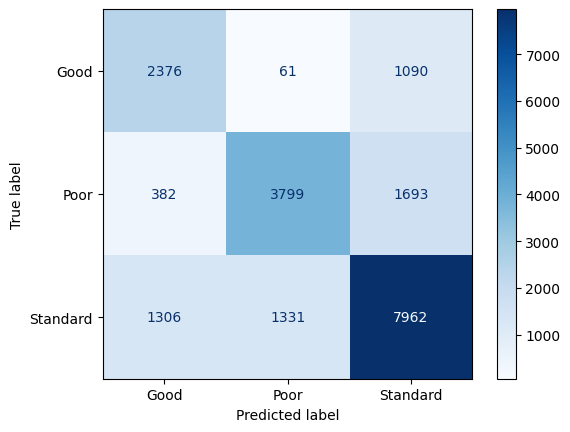

Validation Accuracy: 70.69%
Classification Report:
              precision    recall  f1-score   support

        Good       0.58      0.67      0.63      3527
        Poor       0.73      0.65      0.69      5874
    Standard       0.74      0.75      0.75     10599

    accuracy                           0.71     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.71      0.71      0.71     20000



In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

file_path = 'train2.csv'
data = pd.read_csv(file_path)
data = data.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN'])

# 범주형 데이터 인코딩
categorical_columns = ['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

target_encoder = LabelEncoder()
data['Credit_Score'] = target_encoder.fit_transform(data['Credit_Score'])

# 입력과 타겟 분리 및 스케일링
X = data.drop('Credit_Score', axis=1).values
y = data['Credit_Score'].values
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 데이터셋을 train, valid로 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

class CreditScoreDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CreditScoreDataset(X_train, y_train)
valid_dataset = CreditScoreDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# 모델 정의 (Dropout 추가)
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Dropout 적용

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train.shape[1]
model = MLP(input_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # 학습률 스케줄러

epochs = 20
patience = 3  # Early Stopping의 patience 설정
best_val_accuracy = 0
counter = 0

train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    val_accuracy = 100 * correct_val / total_val
    valid_losses.append(val_loss / len(valid_loader))
    valid_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, '
          f'학습 정확도: {train_accuracy:.2f}%, 평가 정확도: {val_accuracy:.2f}%')

    # Early Stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        counter = 0  # Early Stopping 카운터 초기화
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

    scheduler.step()

# 학습 및 검증 손실/정확도 시각화
epochs_range = range(len(train_losses))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, valid_losses, label='Valid Loss')
plt.legend(loc='best')
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, valid_accuracies, label='Valid Accuracy')
plt.legend(loc='best')
plt.title('Accuracy Over Epochs')
plt.show()

# Confusion Matrix 시각화
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, targets in valid_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Accuracy, Classification Report 출력
accuracy = accuracy_score(all_targets, all_preds)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=target_encoder.classes_))


### 선형회귀

Epoch [1/20], Train Loss: 0.7701, Valid Loss: 0.4903
Epoch [2/20], Train Loss: 0.4894, Valid Loss: 0.4902
Epoch [3/20], Train Loss: 0.4894, Valid Loss: 0.4897
Epoch [4/20], Train Loss: 0.4894, Valid Loss: 0.4918
Epoch [5/20], Train Loss: 0.4893, Valid Loss: 0.4918
Epoch [6/20], Train Loss: 0.4895, Valid Loss: 0.4908
Epoch [7/20], Train Loss: 0.4894, Valid Loss: 0.4906
Epoch [8/20], Train Loss: 0.4895, Valid Loss: 0.4897
Epoch [9/20], Train Loss: 0.4895, Valid Loss: 0.4904
Epoch [10/20], Train Loss: 0.4894, Valid Loss: 0.4922
Epoch [11/20], Train Loss: 0.4896, Valid Loss: 0.4902
Epoch [12/20], Train Loss: 0.4893, Valid Loss: 0.4904
Epoch [13/20], Train Loss: 0.4897, Valid Loss: 0.4902
Epoch [14/20], Train Loss: 0.4894, Valid Loss: 0.4905
Epoch [15/20], Train Loss: 0.4896, Valid Loss: 0.4902
Epoch [16/20], Train Loss: 0.4894, Valid Loss: 0.4901
Epoch [17/20], Train Loss: 0.4894, Valid Loss: 0.4912
Epoch [18/20], Train Loss: 0.4895, Valid Loss: 0.4899
Epoch [19/20], Train Loss: 0.4893, Va

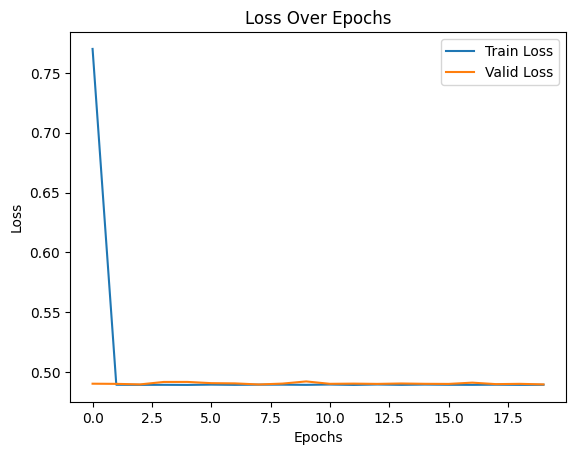

MSE: 0.4897, RMSE: 0.6998


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# 데이터 로드 및 전처리
file_path = 'train2.csv'  # 파일 경로 수정 필요
data = pd.read_csv(file_path)
data = data.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN'])

# 범주형 데이터 인코딩
categorical_columns = ['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Credit_Score를 범주형에서 수치형으로 변환 (레이블 인코딩)
credit_score_encoder = LabelEncoder()
data['Credit_Score'] = credit_score_encoder.fit_transform(data['Credit_Score'])

# 입력과 타겟 분리 및 스케일링
X = data.drop('Credit_Score', axis=1).values
y = data['Credit_Score'].astype(float).values  # 수치형으로 변환된 타겟 변수
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 데이터셋을 train, test로 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

class CreditScoreDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CreditScoreDataset(X_train, y_train)
valid_dataset = CreditScoreDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# 선형 회귀 모델 정의
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train.shape[1]
model = LinearRegressionModel(input_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
train_losses, valid_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device).unsqueeze(1)  # (batch_size, 1) 형태로 맞춤
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

# 학습 및 검증 손실 시각화
epochs_range = range(len(train_losses))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, valid_losses, label='Valid Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# 모델 성능 평가 (MSE, RMSE)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for inputs, targets in valid_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(targets.numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

mse = mean_squared_error(all_targets, all_preds)
rmse = np.sqrt(mse)
print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}')


## 시각화

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


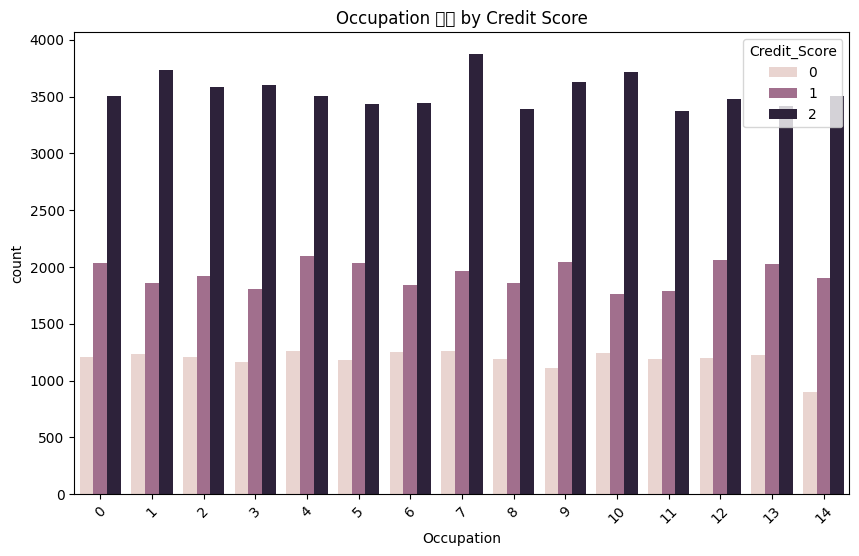

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


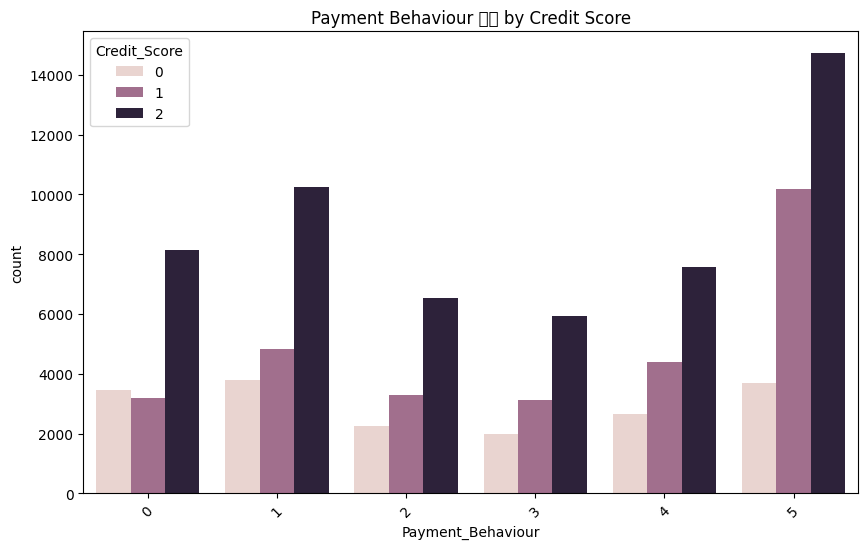

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


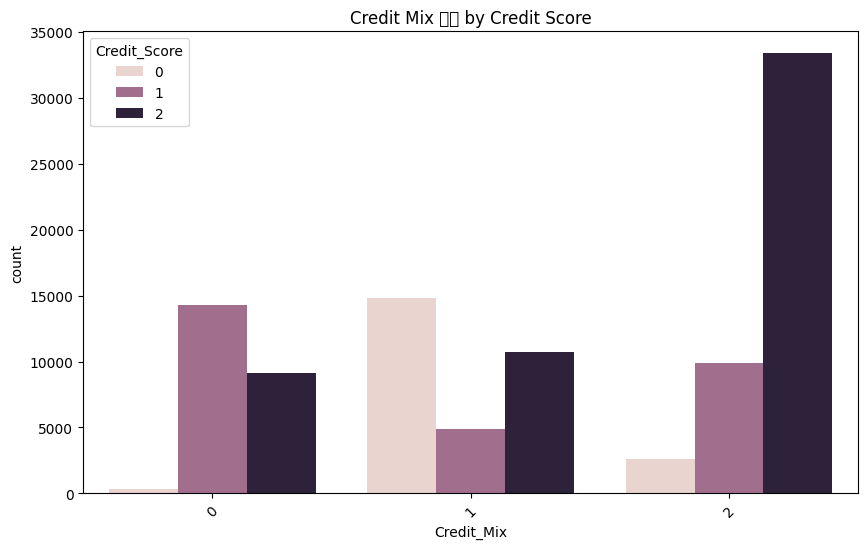

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 데이터를 로드한 후 카테고리형 데이터를 다시 인코딩하기 위해 복원
file_path = 'train2.csv'
data = pd.read_csv(file_path)
data = data.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN'])

# 범주형 변수 인코딩
categorical_columns = ['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

target_encoder = LabelEncoder()
data['Credit_Score'] = target_encoder.fit_transform(data['Credit_Score'])

# 각 클래스의 Occupation 분포 시각화
plt.figure(figsize=(10,6))
sns.countplot(x='Occupation', hue='Credit_Score', data=data)
plt.title('Occupation 분포 by Credit Score')
plt.xticks(rotation=45)
plt.show()

# Payment_Behaviour에 따른 Credit Score 분포
plt.figure(figsize=(10,6))
sns.countplot(x='Payment_Behaviour', hue='Credit_Score', data=data)
plt.title('Payment Behaviour 분포 by Credit Score')
plt.xticks(rotation=45)
plt.show()

# Credit_Mix에 따른 Credit Score 분포
plt.figure(figsize=(10,6))
sns.countplot(x='Credit_Mix', hue='Credit_Score', data=data)
plt.title('Credit Mix 분포 by Credit Score')
plt.xticks(rotation=45)
plt.show()

신용 점수와 변수들 간의 상관관계:
Credit_Score                1.000000
Credit_Mix                  0.229920
Num_of_Delayed_Payment      0.203116
Changed_Credit_Limit        0.190080
Payment_of_Min_Amount       0.179948
Num_Bank_Accounts           0.177389
Interest_Rate               0.121088
Num_Credit_Card             0.113333
Delay_from_due_date         0.097286
Num_Credit_Inquiries        0.067845
Num_of_Loan                 0.064064
Outstanding_Debt            0.037153
Payment_Behaviour           0.024612
Type_of_Loan                0.014924
Occupation                  0.005548
Credit_Utilization_Ratio   -0.014371
Month                      -0.038069
Monthly_Balance            -0.047380
Age                        -0.058923
Total_EMI_per_month        -0.059341
Amount_invested_monthly    -0.068770
Monthly_Inhand_Salary      -0.078770
Annual_Income              -0.080700
Credit_History_Age         -0.102598
Name: Credit_Score, dtype: float64


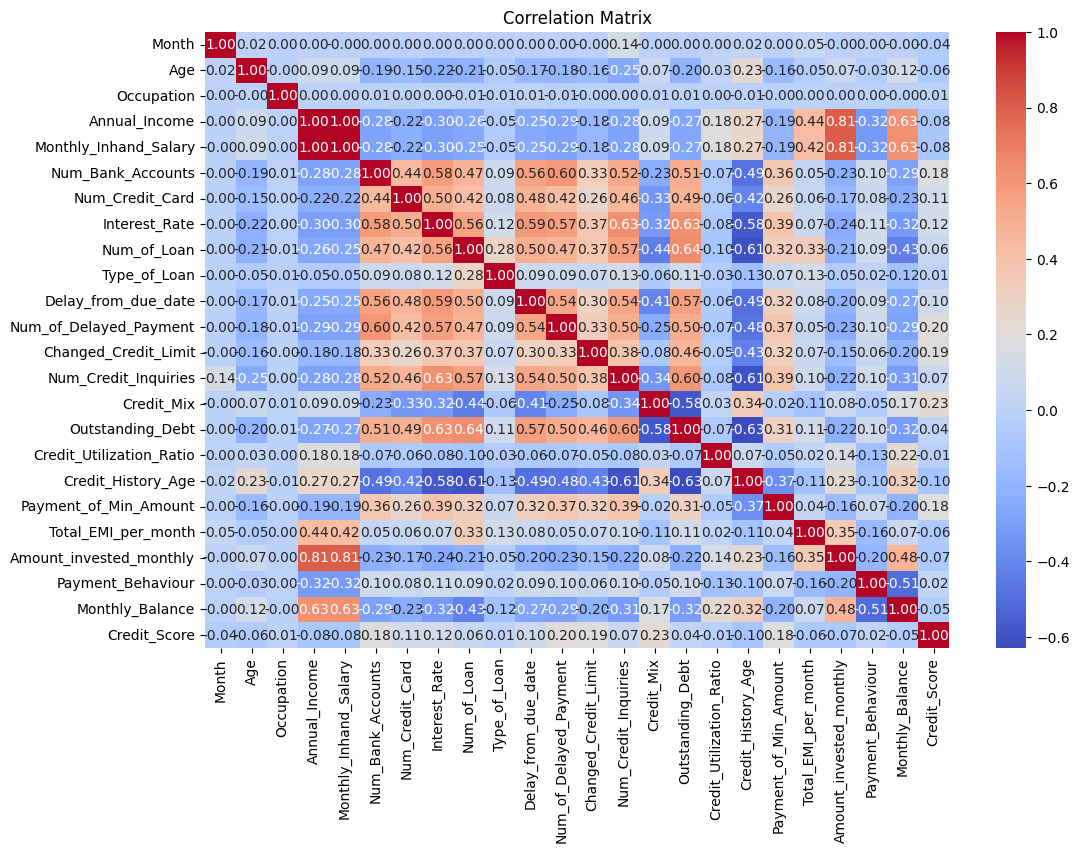

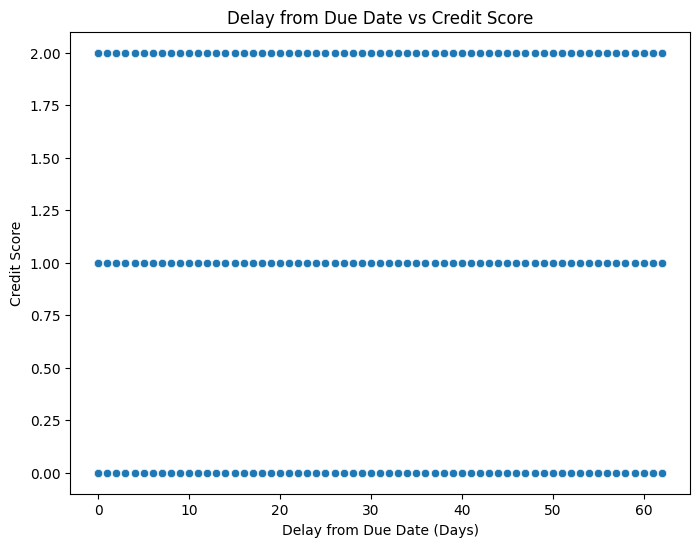

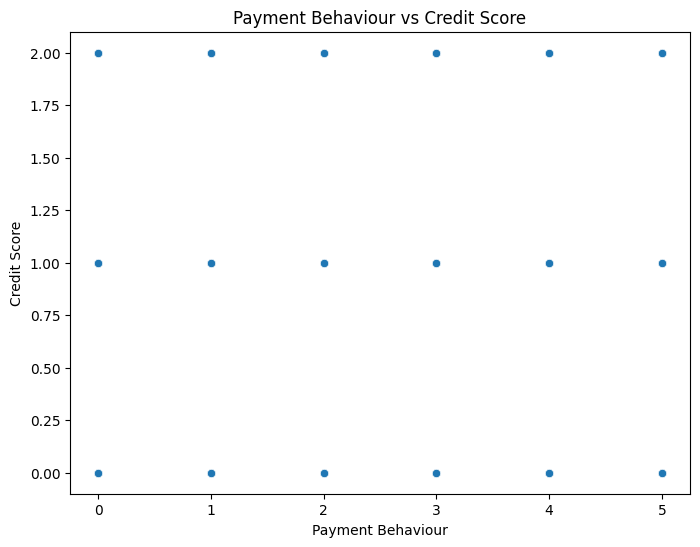

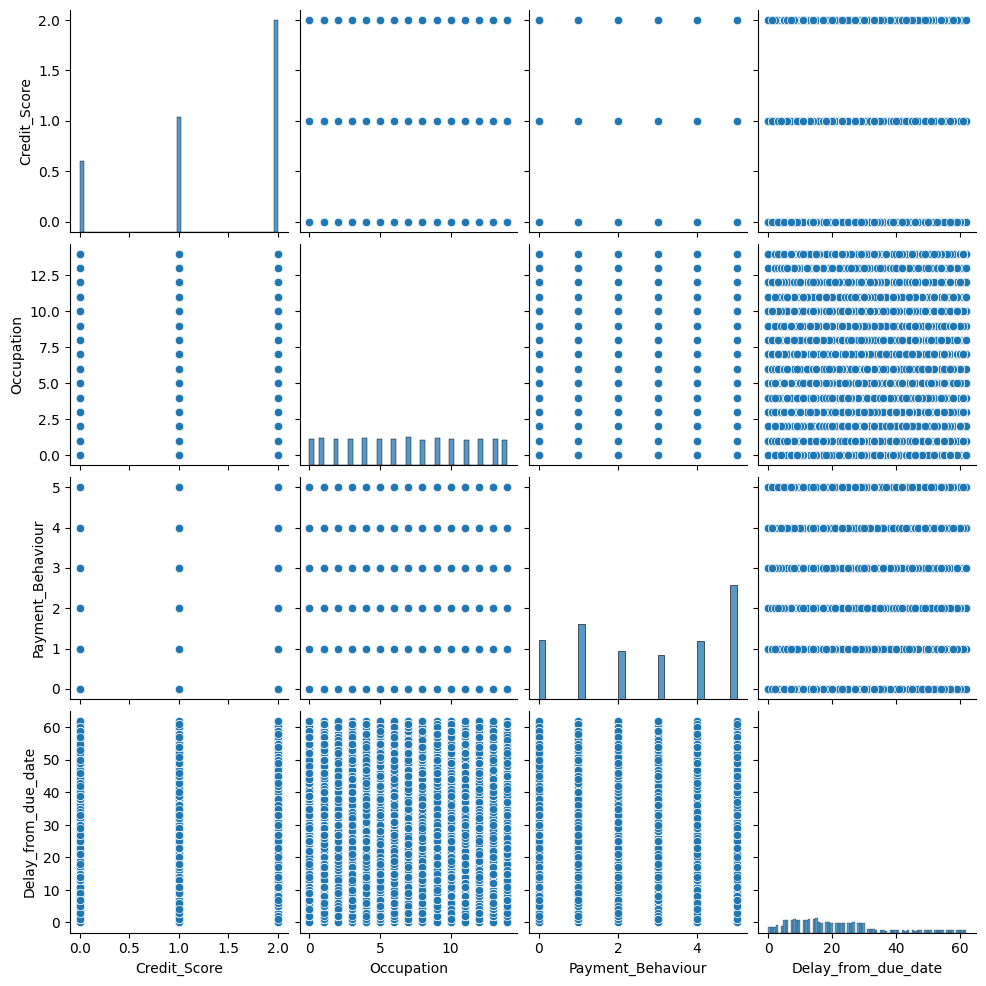

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 데이터 로드 및 전처리
file_path = 'train2.csv'  # 파일 경로 수정 필요
data = pd.read_csv(file_path)

# 불필요한 열 제거
data = data.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN'])

# 범주형 데이터 인코딩
categorical_columns = ['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Credit_Score를 레이블 인코딩
credit_score_encoder = LabelEncoder()
data['Credit_Score'] = credit_score_encoder.fit_transform(data['Credit_Score'])

# 1. 상관관계 분석
correlation_matrix = data.corr()

# 신용 점수와 다른 변수 간의 상관관계
print("신용 점수와 변수들 간의 상관관계:")
print(correlation_matrix['Credit_Score'].sort_values(ascending=False))

# 2. 상관 행렬 시각화 (Heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# 3. 신용 점수와 다른 변수들의 관계 시각화 (Scatter Plot)
# 예시: 'Delay_from_due_date'가 신용 점수와의 관계를 시각화

# Scatter plot 예시 (Delay_from_due_date와 신용 점수 간의 관계)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Delay_from_due_date', y='Credit_Score', data=data)
plt.title('Delay from Due Date vs Credit Score')
plt.xlabel('Delay from Due Date (Days)')
plt.ylabel('Credit Score')
plt.show()

# 다른 변수와의 관계를 파악하고 싶다면 추가적으로 다음과 같이 시각화 가능
# 예: Payment_Behaviour와 Credit_Score의 관계
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Payment_Behaviour', y='Credit_Score', data=data)
plt.title('Payment Behaviour vs Credit Score')
plt.xlabel('Payment Behaviour')
plt.ylabel('Credit Score')
plt.show()

# 여러 변수와 Credit Score 간의 pairplot
sns.pairplot(data[['Credit_Score', 'Occupation', 'Payment_Behaviour', 'Delay_from_due_date']])
plt.show()

## 경향성

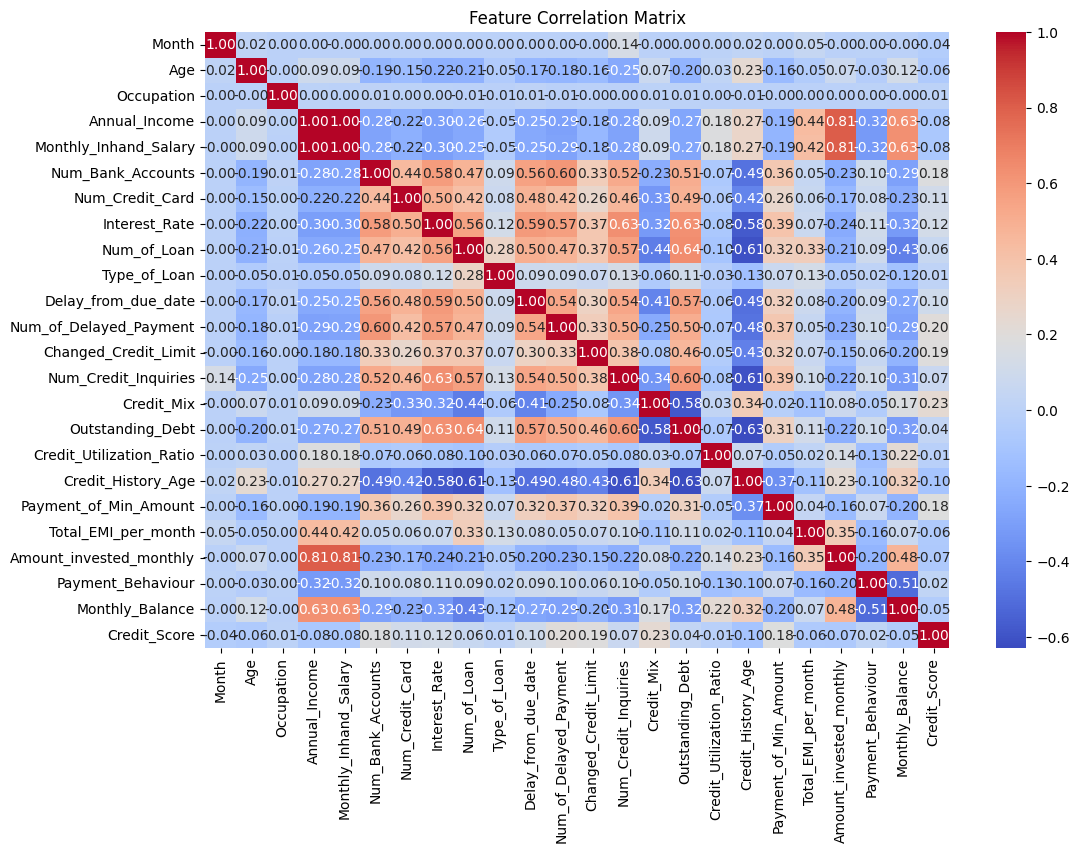

In [ ]:
# 상관관계 분석
correlation_matrix = data.corr()

plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


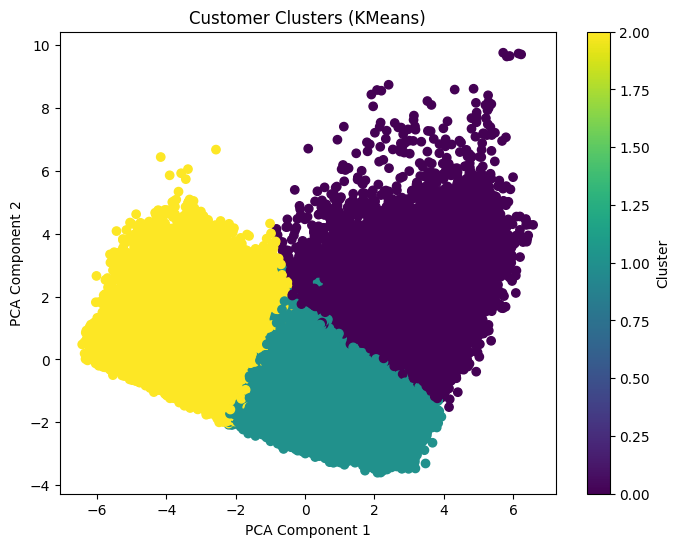

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

# 데이터 표준화
X = data.drop('Credit_Score', axis=1).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# PCA를 통한 시각화 (2차원 축소)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('Customer Clusters (KMeans)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
# 클래스별 평균값 확인
class_means = data.groupby('Credit_Score').mean()

print("클래스별 평균 특성 값:\n", class_means)

클래스별 평균 특성 값:
                  Month        Age  Occupation  Annual_Income  \
Credit_Score                                                   
0             4.671864  36.402625    6.863698   65203.672105   
1             4.518760  31.194565    6.992689   40584.515325   
2             4.432147  33.438673    6.955354   50987.164840   

              Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card  \
Credit_Score                                                              
0                       5399.919696           3.440263         4.143258   
1                       3380.560657           6.526726         6.625147   
2                       4239.436890           5.383966         5.404427   

              Interest_Rate  Num_of_Loan  Type_of_Loan  ...  \
Credit_Score                                            ...   
0                  7.662329     2.202154   2489.043639  ...   
1                 20.187116     4.755742   2970.732533  ...   
2                 13.751420     3.31

Occupation에 따른 전략: 특정 직업군(예: 'Occupation' 값이 특정 코드에 집중된 경우)에 맞는 특화 금융 상품이나 할인 혜택을 제공할 수 있음. \
Payment Behaviour: 결제 성향이 낮은 고객 그룹에게는 자동 결제 시스템이나 할인 쿠폰을 통한 결제 유도 캠페인이 유효할 수 있음. \
Credit Mix: 다양한 대출 유형을 사용하는 그룹에게는 맞춤형 대출 상품(예: 기존 대출 통합 대출) 제안이 유리할 수 있음.

# 파생변수 생성 후

## 파생변수

   Total_Debt_Ratio  Interest_Burden  Credit_Usage_Limit_Ratio  \
0          0.042376          2429.94                  2.380002   
1          0.042376          2429.94                  2.834513   
2          0.042376          2429.94                  2.538541   
3          0.042376          2429.94                  5.004444   
4          0.042376          2429.94                  2.200297   

   Delinquency_Rate  Loans_to_Credit_Cards_Ratio  
0              1.75                          1.0  
1              1.00                          1.0  
2              1.75                          1.0  
3              1.00                          1.0  
4              1.00                          1.0  
신용 점수와 파생변수들 간의 상관관계:
Credit_Score                   1.000000
Credit_Mix                     0.229920
Num_of_Delayed_Payment         0.203116
Changed_Credit_Limit           0.190080
Payment_of_Min_Amount          0.179948
Num_Bank_Accounts              0.177389
Interest_Rate                  0.12

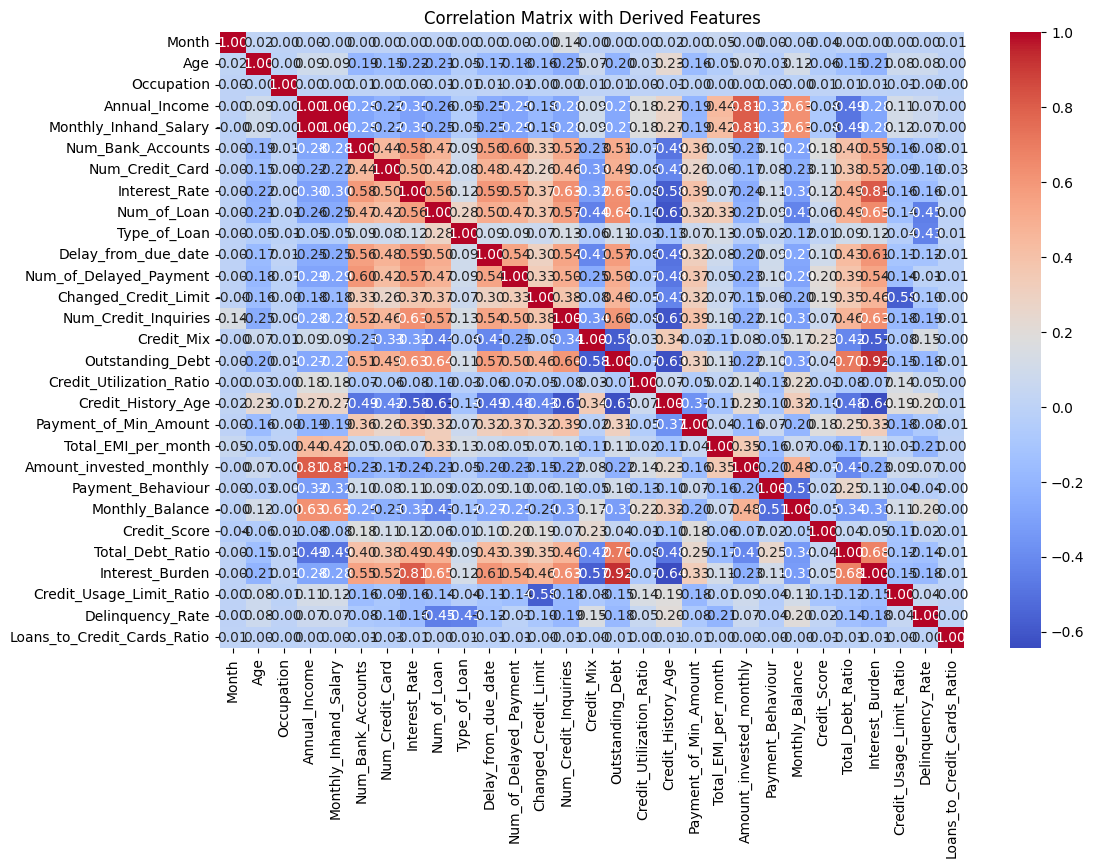

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 데이터 로드 및 전처리
file_path = 'train2.csv'  # 파일 경로 수정 필요
data = pd.read_csv(file_path)

# 불필요한 열 제거
data = data.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN'])

# 범주형 데이터 인코딩
categorical_columns = ['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Credit_Score를 레이블 인코딩
credit_score_encoder = LabelEncoder()
data['Credit_Score'] = credit_score_encoder.fit_transform(data['Credit_Score'])

# 파생 변수 생성

# 1. Total Debt Ratio (총 대출 부채 비율)
data['Total_Debt_Ratio'] = data['Outstanding_Debt'] / data['Annual_Income']

# 2. Interest Burden (이자 부담)
data['Interest_Burden'] = data['Interest_Rate'] * data['Outstanding_Debt']

# 3. Credit Card Usage to Limit Ratio (신용카드 사용량 대비 한도 비율)
data['Credit_Usage_Limit_Ratio'] = data['Credit_Utilization_Ratio'] / (data['Changed_Credit_Limit'] + 1e-9)  # 0으로 나누는 것을 방지

# 4. Delinquency Rate (연체율)
data['Delinquency_Rate'] = data['Num_of_Delayed_Payment'] / (data['Num_of_Loan'] + 1e-9)  # 대출 수가 0일 때 방지

# 5. Loans to Credit Cards Ratio (대출 수 대비 신용카드 수 비율)
data['Loans_to_Credit_Cards_Ratio'] = data['Num_of_Loan'] / (data['Num_Credit_Card'] + 1e-9)

# 파생 변수들을 출력하여 확인
print(data[['Total_Debt_Ratio', 'Interest_Burden', 'Credit_Usage_Limit_Ratio', 'Delinquency_Rate', 'Loans_to_Credit_Cards_Ratio']].head())

# 상관관계 분석
correlation_matrix = data.corr()
print("신용 점수와 파생변수들 간의 상관관계:")
print(correlation_matrix['Credit_Score'].sort_values(ascending=False))

# 상관 행렬 시각화 (Heatmap)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix with Derived Features')
plt.show()

## 기본 모델링

### MLP

Epoch [1/20], Loss: 0.7094, 학습 정확도: 67.32%, 평가 정확도: 69.83%
Epoch [2/20], Loss: 0.6707, 학습 정확도: 69.38%, 평가 정확도: 70.31%
Epoch [3/20], Loss: 0.6599, 학습 정확도: 70.02%, 평가 정확도: 70.48%
Epoch [4/20], Loss: 0.6550, 학습 정확도: 70.05%, 평가 정확도: 70.52%
Epoch [5/20], Loss: 0.6489, 학습 정확도: 70.39%, 평가 정확도: 70.65%
Epoch [6/20], Loss: 0.6418, 학습 정확도: 70.69%, 평가 정확도: 70.66%
Epoch [7/20], Loss: 0.6398, 학습 정확도: 70.69%, 평가 정확도: 70.69%
Epoch [8/20], Loss: 0.6394, 학습 정확도: 70.80%, 평가 정확도: 70.78%
Epoch [9/20], Loss: 0.6377, 학습 정확도: 70.99%, 평가 정확도: 70.72%
Epoch [10/20], Loss: 0.6365, 학습 정확도: 70.85%, 평가 정확도: 70.73%
Epoch [11/20], Loss: 0.6356, 학습 정확도: 70.83%, 평가 정확도: 70.73%
Early stopping!


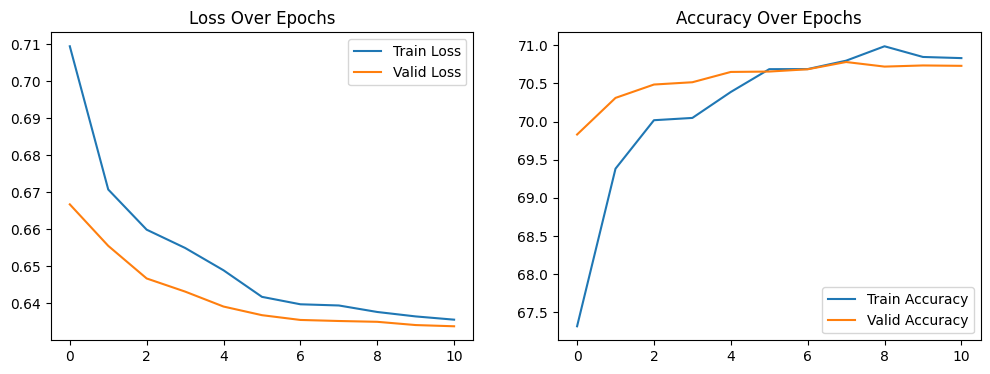

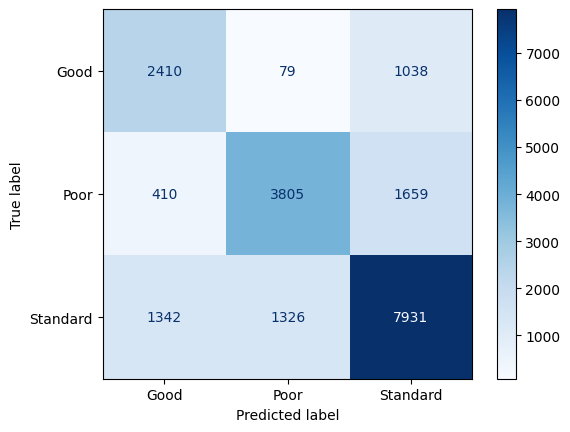

Validation Accuracy: 70.73%
Classification Report:
              precision    recall  f1-score   support

        Good       0.58      0.68      0.63      3527
        Poor       0.73      0.65      0.69      5874
    Standard       0.75      0.75      0.75     10599

    accuracy                           0.71     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.71      0.71      0.71     20000



In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import numpy as np

# 데이터 로드 및 전처리
file_path = 'train2.csv'
data = pd.read_csv(file_path)
data = data.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN'])

# 범주형 데이터 인코딩
categorical_columns = ['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Credit_Score를 레이블 인코딩
target_encoder = LabelEncoder()
data['Credit_Score'] = target_encoder.fit_transform(data['Credit_Score'])

# 파생 변수 생성
# 1. Total Debt Ratio (총 대출 부채 비율)
data['Total_Debt_Ratio'] = data['Outstanding_Debt'] / data['Annual_Income']

# 2. Interest Burden (이자 부담)
data['Interest_Burden'] = data['Interest_Rate'] * data['Outstanding_Debt']

# 3. Credit Card Usage to Limit Ratio (신용카드 사용량 대비 한도 비율)
data['Credit_Usage_Limit_Ratio'] = data['Credit_Utilization_Ratio'] / (data['Changed_Credit_Limit'] + 1e-9)  # 0으로 나누는 것을 방지

# 4. Delinquency Rate (연체율)
data['Delinquency_Rate'] = data['Num_of_Delayed_Payment'] / (data['Num_of_Loan'] + 1e-9)  # 대출 수가 0일 때 방지

# 5. Loans to Credit Cards Ratio (대출 수 대비 신용카드 수 비율)
data['Loans_to_Credit_Cards_Ratio'] = data['Num_of_Loan'] / (data['Num_Credit_Card'] + 1e-9)

# 입력과 타겟 분리 및 스케일링
X = data.drop('Credit_Score', axis=1).values
y = data['Credit_Score'].values
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 데이터셋을 train, valid로 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

class CreditScoreDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CreditScoreDataset(X_train, y_train)
valid_dataset = CreditScoreDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# 모델 정의 (Dropout 추가)
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Dropout 적용

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train.shape[1]  # 입력 크기 변경 (파생변수를 포함한 전체 피처 수)
model = MLP(input_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # 학습률 스케줄러

epochs = 20
patience = 3  # Early Stopping의 patience 설정
best_val_accuracy = 0
counter = 0

train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    val_accuracy = 100 * correct_val / total_val
    valid_losses.append(val_loss / len(valid_loader))
    valid_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, '
          f'학습 정확도: {train_accuracy:.2f}%, 평가 정확도: {val_accuracy:.2f}%')

    # Early Stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        counter = 0  # Early Stopping 카운터 초기화
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

    scheduler.step()

# 학습 및 검증 손실/정확도 시각화
epochs_range = range(len(train_losses))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, valid_losses, label='Valid Loss')
plt.legend(loc='best')
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, valid_accuracies, label='Valid Accuracy')
plt.legend(loc='best')
plt.title('Accuracy Over Epochs')
plt.show()

# Confusion Matrix 및 Classification Report
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, targets in valid_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# Confusion Matrix 시각화
cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Accuracy, Classification Report 출력
accuracy = accuracy_score(all_targets, all_preds)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=target_encoder.classes_))


### 선형회귀

Epoch [1/20], Train Loss: 1.0149, Valid Loss: 0.4942
Epoch [2/20], Train Loss: 0.4898, Valid Loss: 0.4901
Epoch [3/20], Train Loss: 0.4897, Valid Loss: 0.4904
Epoch [4/20], Train Loss: 0.4895, Valid Loss: 0.4906
Epoch [5/20], Train Loss: 0.4897, Valid Loss: 0.4901
Epoch [6/20], Train Loss: 0.4896, Valid Loss: 0.4908
Epoch [7/20], Train Loss: 0.4896, Valid Loss: 0.4908
Epoch [8/20], Train Loss: 0.4896, Valid Loss: 0.4892
Epoch [9/20], Train Loss: 0.4895, Valid Loss: 0.4914
Epoch [10/20], Train Loss: 0.4895, Valid Loss: 0.4906
Epoch [11/20], Train Loss: 0.4896, Valid Loss: 0.4896
Epoch [12/20], Train Loss: 0.4894, Valid Loss: 0.4909
Epoch [13/20], Train Loss: 0.4895, Valid Loss: 0.4916
Epoch [14/20], Train Loss: 0.4895, Valid Loss: 0.4909
Epoch [15/20], Train Loss: 0.4894, Valid Loss: 0.4896
Epoch [16/20], Train Loss: 0.4895, Valid Loss: 0.4898
Epoch [17/20], Train Loss: 0.4894, Valid Loss: 0.4901
Epoch [18/20], Train Loss: 0.4894, Valid Loss: 0.4910
Epoch [19/20], Train Loss: 0.4895, Va

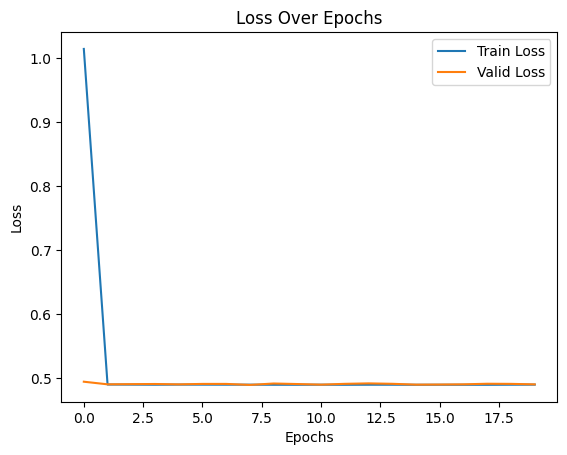

MSE: 0.4901, RMSE: 0.7001, R² Score: 0.1569


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score  # R² 스코어 추가
import numpy as np

# 데이터 로드 및 전처리
file_path = 'train2.csv'  # 파일 경로 수정 필요
data = pd.read_csv(file_path)
data = data.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN'])

# 범주형 데이터 인코딩
categorical_columns = ['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Credit_Score를 범주형에서 수치형으로 변환 (레이블 인코딩)
credit_score_encoder = LabelEncoder()
data['Credit_Score'] = credit_score_encoder.fit_transform(data['Credit_Score'])

# 입력과 타겟 분리 및 스케일링
X = data.drop('Credit_Score', axis=1).values
y = data['Credit_Score'].astype(float).values  # 수치형으로 변환된 타겟 변수
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 데이터셋을 train, test로 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

class CreditScoreDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CreditScoreDataset(X_train, y_train)
valid_dataset = CreditScoreDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# 선형 회귀 모델 정의
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train.shape[1]
model = LinearRegressionModel(input_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
train_losses, valid_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device).unsqueeze(1)  # (batch_size, 1) 형태로 맞춤
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

# 학습 및 검증 손실 시각화
epochs_range = range(len(train_losses))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, valid_losses, label='Valid Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# 모델 성능 평가 (MSE, RMSE, R² 스코어)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for inputs, targets in valid_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(targets.numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

mse = mean_squared_error(all_targets, all_preds)
rmse = np.sqrt(mse)
r2 = r2_score(all_targets, all_preds)  # R² 스코어 계산

print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, R² Score: {r2:.4f}')


## 시각화

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


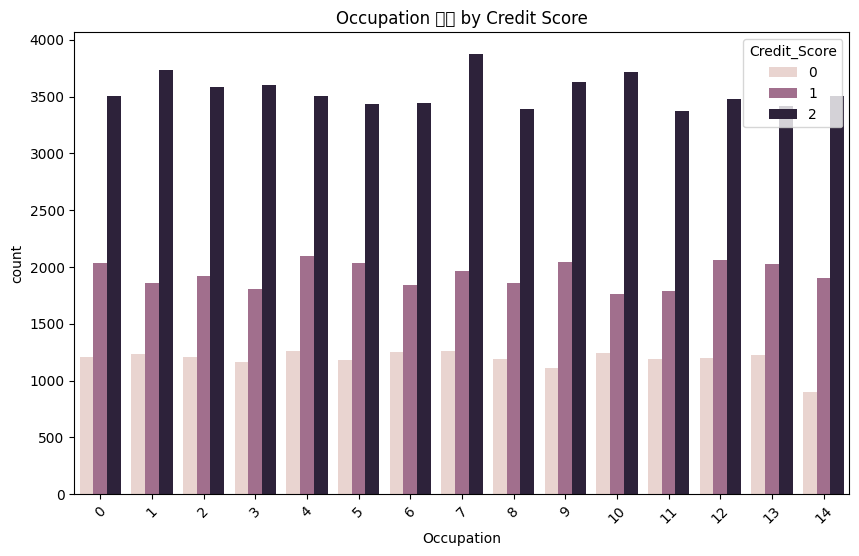

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


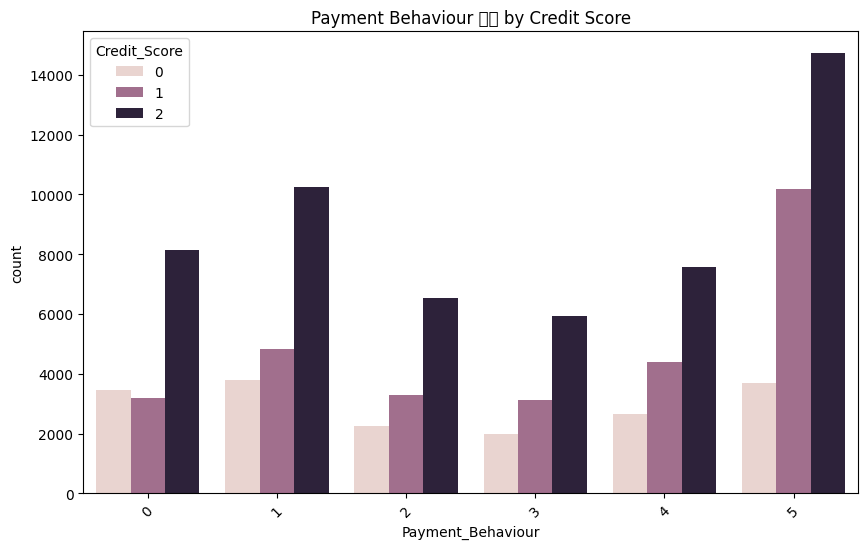

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


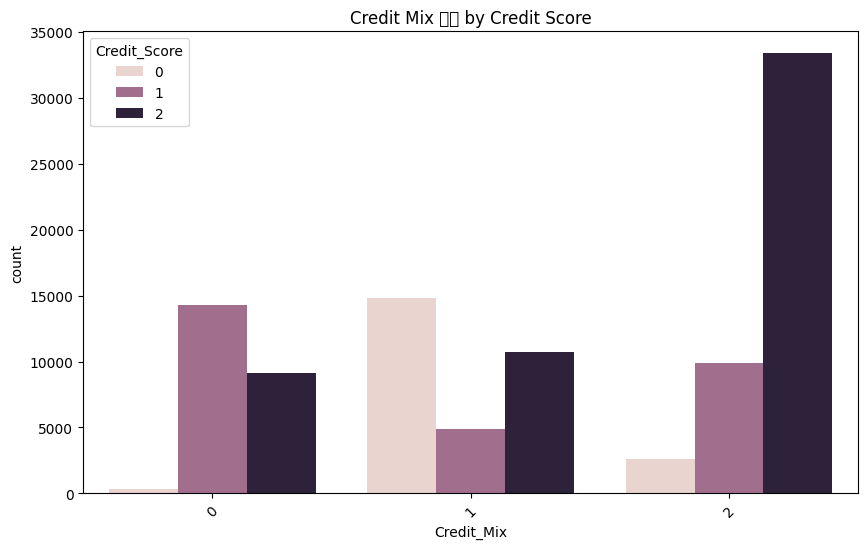

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


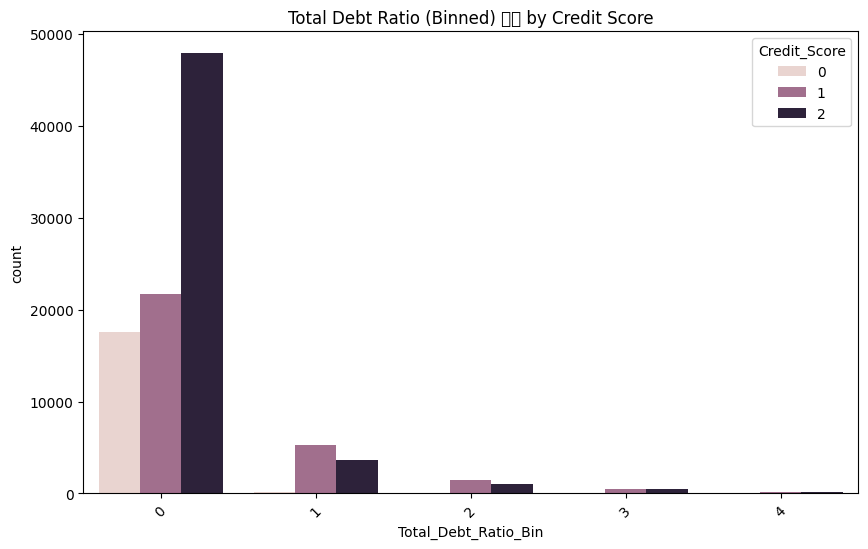

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


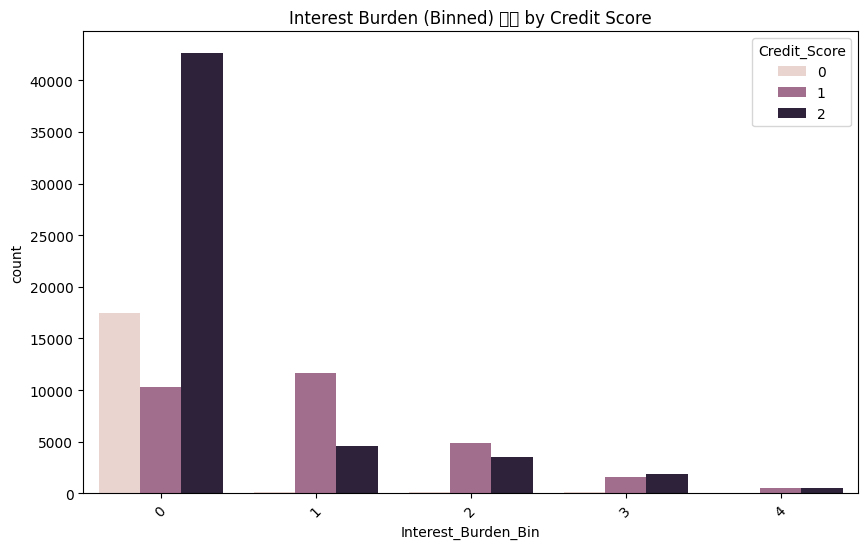

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


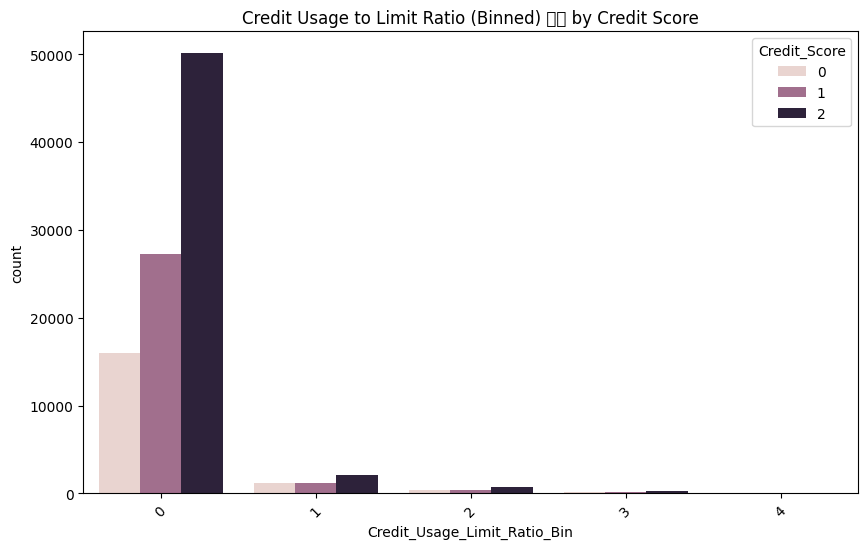

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


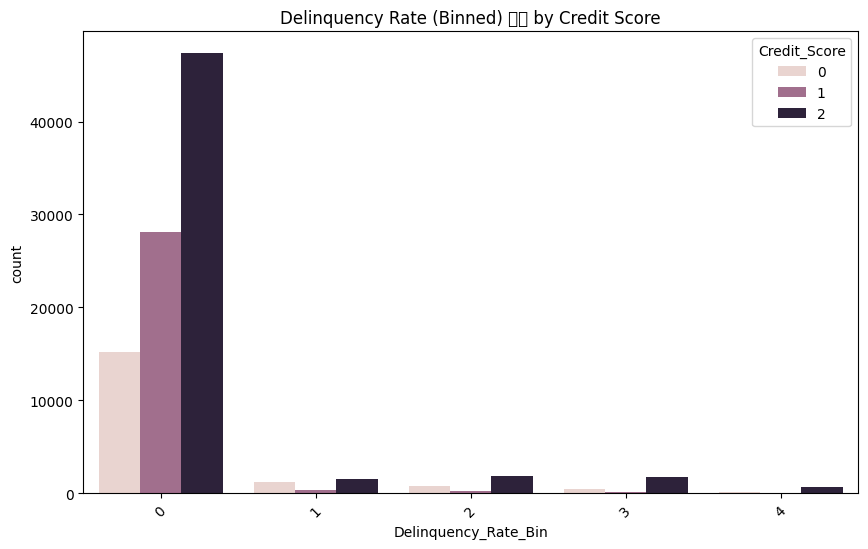

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


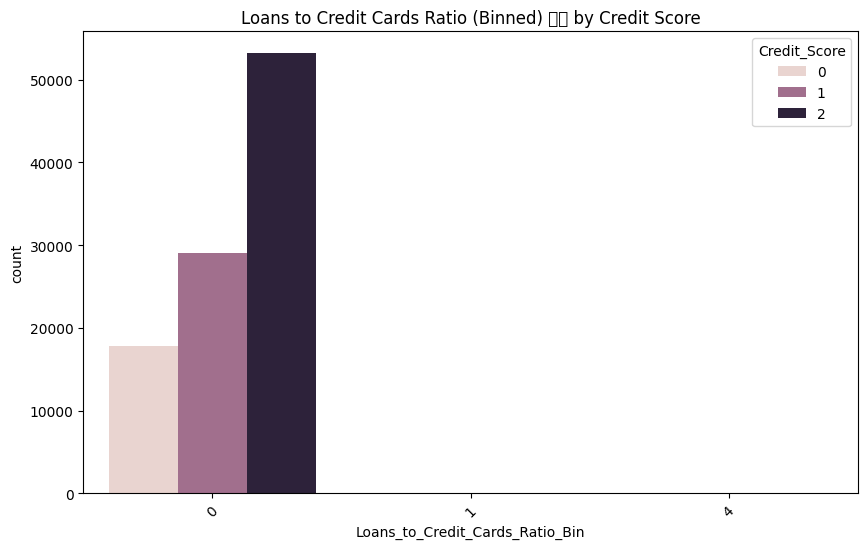

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 데이터를 로드한 후 카테고리형 데이터를 다시 인코딩하기 위해 복원
file_path = 'train2.csv'
data = pd.read_csv(file_path)
data = data.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN'])

# 범주형 변수 인코딩
categorical_columns = ['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

target_encoder = LabelEncoder()
data['Credit_Score'] = target_encoder.fit_transform(data['Credit_Score'])

# 파생 변수 생성
# 1. Total Debt Ratio (총 대출 부채 비율)
data['Total_Debt_Ratio'] = data['Outstanding_Debt'] / data['Annual_Income']

# 2. Interest Burden (이자 부담)
data['Interest_Burden'] = data['Interest_Rate'] * data['Outstanding_Debt']

# 3. Credit Card Usage to Limit Ratio (신용카드 사용량 대비 한도 비율)
data['Credit_Usage_Limit_Ratio'] = data['Credit_Utilization_Ratio'] / (data['Changed_Credit_Limit'] + 1e-9)

# 4. Delinquency Rate (연체율)
data['Delinquency_Rate'] = data['Num_of_Delayed_Payment'] / (data['Num_of_Loan'] + 1e-9)

# 5. Loans to Credit Cards Ratio (대출 수 대비 신용카드 수 비율)
data['Loans_to_Credit_Cards_Ratio'] = data['Num_of_Loan'] / (data['Num_Credit_Card'] + 1e-9)

# 파생 변수를 구간화(bin)
data['Total_Debt_Ratio_Bin'] = pd.cut(data['Total_Debt_Ratio'], bins=5, labels=False)
data['Interest_Burden_Bin'] = pd.cut(data['Interest_Burden'], bins=5, labels=False)
data['Credit_Usage_Limit_Ratio_Bin'] = pd.cut(data['Credit_Usage_Limit_Ratio'], bins=5, labels=False)
data['Delinquency_Rate_Bin'] = pd.cut(data['Delinquency_Rate'], bins=5, labels=False)
data['Loans_to_Credit_Cards_Ratio_Bin'] = pd.cut(data['Loans_to_Credit_Cards_Ratio'], bins=5, labels=False)

# 각 클래스의 Occupation 분포 시각화
plt.figure(figsize=(10,6))
sns.countplot(x='Occupation', hue='Credit_Score', data=data)
plt.title('Occupation 분포 by Credit Score')
plt.xticks(rotation=45)
plt.show()

# Payment_Behaviour에 따른 Credit Score 분포
plt.figure(figsize=(10,6))
sns.countplot(x='Payment_Behaviour', hue='Credit_Score', data=data)
plt.title('Payment Behaviour 분포 by Credit Score')
plt.xticks(rotation=45)
plt.show()

# Credit_Mix에 따른 Credit Score 분포
plt.figure(figsize=(10,6))
sns.countplot(x='Credit_Mix', hue='Credit_Score', data=data)
plt.title('Credit Mix 분포 by Credit Score')
plt.xticks(rotation=45)
plt.show()

# 파생 변수들의 구간화된 값에 따른 Credit Score 분포 시각화
plt.figure(figsize=(10,6))
sns.countplot(x='Total_Debt_Ratio_Bin', hue='Credit_Score', data=data)
plt.title('Total Debt Ratio (Binned) 분포 by Credit Score')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(x='Interest_Burden_Bin', hue='Credit_Score', data=data)
plt.title('Interest Burden (Binned) 분포 by Credit Score')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(x='Credit_Usage_Limit_Ratio_Bin', hue='Credit_Score', data=data)
plt.title('Credit Usage to Limit Ratio (Binned) 분포 by Credit Score')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(x='Delinquency_Rate_Bin', hue='Credit_Score', data=data)
plt.title('Delinquency Rate (Binned) 분포 by Credit Score')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(x='Loans_to_Credit_Cards_Ratio_Bin', hue='Credit_Score', data=data)
plt.title('Loans to Credit Cards Ratio (Binned) 분포 by Credit Score')
plt.xticks(rotation=45)
plt.show()


그래프 수치들

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 데이터를 로드한 후 카테고리형 데이터를 다시 인코딩하기 위해 복원
file_path = 'train2.csv'
data = pd.read_csv(file_path)
data = data.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN'])

# 범주형 변수 인코딩
categorical_columns = ['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

target_encoder = LabelEncoder()
data['Credit_Score'] = target_encoder.fit_transform(data['Credit_Score'])

# 파생 변수 생성
# 1. Total Debt Ratio (총 대출 부채 비율)
data['Total_Debt_Ratio'] = data['Outstanding_Debt'] / data['Annual_Income']

# 2. Interest Burden (이자 부담)
data['Interest_Burden'] = data['Interest_Rate'] * data['Outstanding_Debt']

# 3. Credit Card Usage to Limit Ratio (신용카드 사용량 대비 한도 비율)
data['Credit_Usage_Limit_Ratio'] = data['Credit_Utilization_Ratio'] / (data['Changed_Credit_Limit'] + 1e-9)

# 4. Delinquency Rate (연체율)
data['Delinquency_Rate'] = data['Num_of_Delayed_Payment'] / (data['Num_of_Loan'] + 1e-9)

# 5. Loans to Credit Cards Ratio (대출 수 대비 신용카드 수 비율)
data['Loans_to_Credit_Cards_Ratio'] = data['Num_of_Loan'] / (data['Num_Credit_Card'] + 1e-9)

# 파생 변수를 구간화(bin)
data['Total_Debt_Ratio_Bin'] = pd.cut(data['Total_Debt_Ratio'], bins=5, labels=False)
data['Interest_Burden_Bin'] = pd.cut(data['Interest_Burden'], bins=5, labels=False)
data['Credit_Usage_Limit_Ratio_Bin'] = pd.cut(data['Credit_Usage_Limit_Ratio'], bins=5, labels=False)
data['Delinquency_Rate_Bin'] = pd.cut(data['Delinquency_Rate'], bins=5, labels=False)
data['Loans_to_Credit_Cards_Ratio_Bin'] = pd.cut(data['Loans_to_Credit_Cards_Ratio'], bins=5, labels=False)

# 1. Occupation에 따른 Credit Score 분포 수치
occupation_crosstab = pd.crosstab(data['Occupation'], data['Credit_Score'])
print("Occupation에 따른 Credit Score 분포:\n", occupation_crosstab)

# 2. Payment_Behaviour에 따른 Credit Score 분포 수치
payment_behaviour_crosstab = pd.crosstab(data['Payment_Behaviour'], data['Credit_Score'])
print("\nPayment_Behaviour에 따른 Credit Score 분포:\n", payment_behaviour_crosstab)

# 3. Credit_Mix에 따른 Credit Score 분포 수치
credit_mix_crosstab = pd.crosstab(data['Credit_Mix'], data['Credit_Score'])
print("\nCredit_Mix에 따른 Credit Score 분포:\n", credit_mix_crosstab)

# 4. Total Debt Ratio (Binned)에 따른 Credit Score 분포 수치
total_debt_ratio_crosstab = pd.crosstab(data['Total_Debt_Ratio_Bin'], data['Credit_Score'])
print("\nTotal Debt Ratio (Binned)에 따른 Credit Score 분포:\n", total_debt_ratio_crosstab)

# 5. Interest Burden (Binned)에 따른 Credit Score 분포 수치
interest_burden_crosstab = pd.crosstab(data['Interest_Burden_Bin'], data['Credit_Score'])
print("\nInterest Burden (Binned)에 따른 Credit Score 분포:\n", interest_burden_crosstab)

# 6. Credit Usage Limit Ratio (Binned)에 따른 Credit Score 분포 수치
credit_usage_limit_ratio_crosstab = pd.crosstab(data['Credit_Usage_Limit_Ratio_Bin'], data['Credit_Score'])
print("\nCredit Usage Limit Ratio (Binned)에 따른 Credit Score 분포:\n", credit_usage_limit_ratio_crosstab)

# 7. Delinquency Rate (Binned)에 따른 Credit Score 분포 수치
delinquency_rate_crosstab = pd.crosstab(data['Delinquency_Rate_Bin'], data['Credit_Score'])
print("\nDelinquency Rate (Binned)에 따른 Credit Score 분포:\n", delinquency_rate_crosstab)

# 8. Loans to Credit Cards Ratio (Binned)에 따른 Credit Score 분포 수치
loans_to_credit_cards_ratio_crosstab = pd.crosstab(data['Loans_to_Credit_Cards_Ratio_Bin'], data['Credit_Score'])
print("\nLoans to Credit Cards Ratio (Binned)에 따른 Credit Score 분포:\n", loans_to_credit_cards_ratio_crosstab)


Occupation에 따른 Credit Score 분포:
 Credit_Score     0     1     2
Occupation                    
0             1205  2037  3502
1             1233  1855  3736
2             1210  1924  3586
3             1164  1804  3600
4             1264  2094  3506
5             1185  2033  3430
6             1254  1840  3442
7             1259  1965  3872
8             1190  1856  3386
9             1107  2044  3625
10            1244  1764  3712
11            1192  1786  3374
12            1201  2062  3481
13            1224  2027  3421
14             896  1907  3501

Payment_Behaviour에 따른 Credit Score 분포:
 Credit_Score          0      1      2
Payment_Behaviour                    
0                  3446   3182   8150
1                  3780   4816  10255
2                  2256   3308   6541
3                  1984   3119   5944
4                  2668   4400   7566
5                  3694  10173  14718

Credit_Mix에 따른 Credit Score 분포:
 Credit_Score      0      1      2
Credit_Mix                 

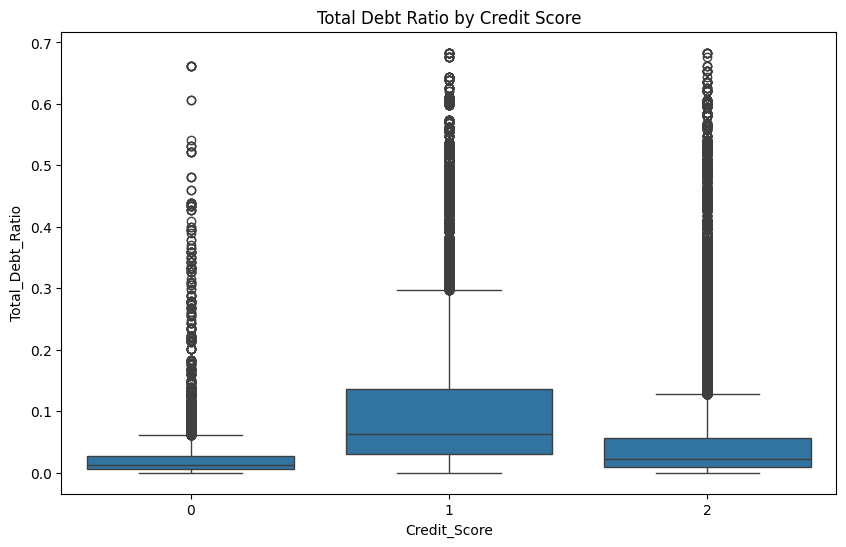

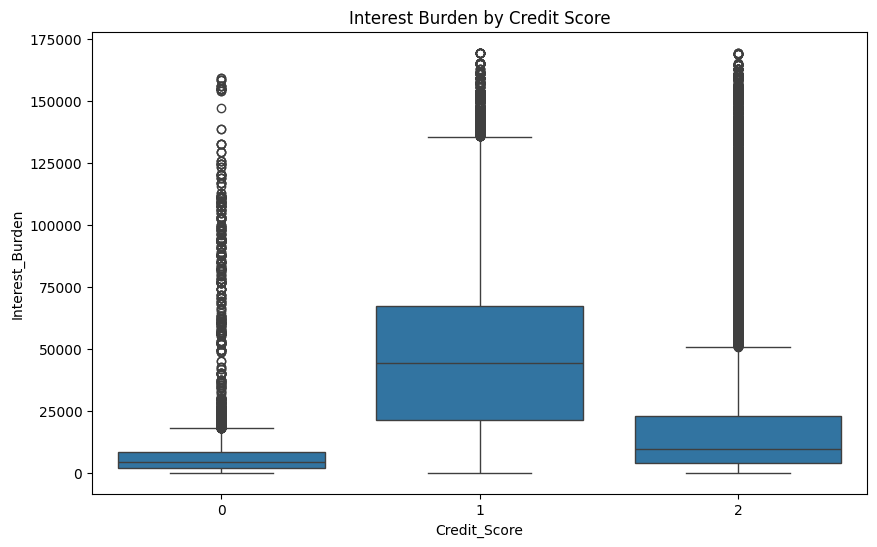

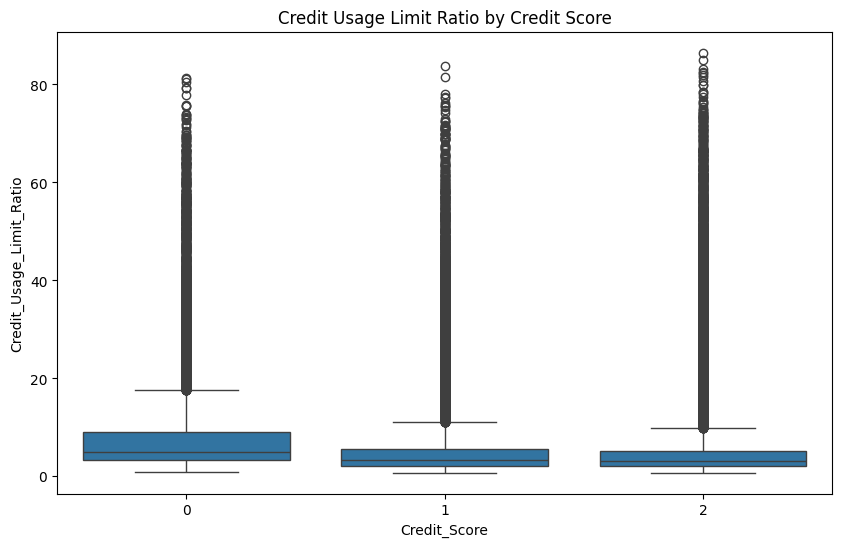

In [6]:
# Total Debt Ratio에 따른 Credit_Score 박스플롯
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x='Credit_Score', y='Total_Debt_Ratio', data=data)
plt.title('Total Debt Ratio by Credit Score')
plt.show()

# Interest Burden에 따른 Credit_Score 박스플롯
plt.figure(figsize=(10, 6))
sns.boxplot(x='Credit_Score', y='Interest_Burden', data=data)
plt.title('Interest Burden by Credit Score')
plt.show()

# Credit Usage Limit Ratio에 따른 Credit_Score 박스플롯
plt.figure(figsize=(10, 6))
sns.boxplot(x='Credit_Score', y='Credit_Usage_Limit_Ratio', data=data)
plt.title('Credit Usage Limit Ratio by Credit Score')
plt.show()


## 경향성

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 데이터 로드 및 전처리
file_path = 'train2.csv'
data = pd.read_csv(file_path)
data = data.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN'])

# 범주형 변수 인코딩
categorical_columns = ['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Credit_Score 인코딩
target_encoder = LabelEncoder()
data['Credit_Score'] = target_encoder.fit_transform(data['Credit_Score'])

# 파생 변수 생성
data['Total_Debt_Ratio'] = data['Outstanding_Debt'] / data['Annual_Income']
data['Interest_Burden'] = data['Interest_Rate'] * data['Outstanding_Debt']
data['Credit_Usage_Limit_Ratio'] = data['Credit_Utilization_Ratio'] / (data['Changed_Credit_Limit'] + 1e-9)
data['Delinquency_Rate'] = data['Num_of_Delayed_Payment'] / (data['Num_of_Loan'] + 1e-9)
data['Loans_to_Credit_Cards_Ratio'] = data['Num_of_Loan'] / (data['Num_Credit_Card'] + 1e-9)

# 1. 파생 변수와 Credit_Score 간의 상관관계 분석
correlation_matrix = data[['Total_Debt_Ratio', 'Interest_Burden', 'Credit_Usage_Limit_Ratio',
                           'Delinquency_Rate', 'Loans_to_Credit_Cards_Ratio', 'Credit_Score']].corr()
print("파생 변수와 Credit_Score 간의 상관관계:\n", correlation_matrix['Credit_Score'].sort_values(ascending=False))

# 2. 파생 변수에 따른 Credit_Score 평균값 계산 (경향성 파악)
# Total_Debt_Ratio에 따른 Credit_Score 경향성
total_debt_ratio_mean = data.groupby(pd.cut(data['Total_Debt_Ratio'], bins=5))['Credit_Score'].mean()
print("\nTotal Debt Ratio에 따른 Credit_Score 평균:\n", total_debt_ratio_mean)

# Interest_Burden에 따른 Credit_Score 경향성
interest_burden_mean = data.groupby(pd.cut(data['Interest_Burden'], bins=5))['Credit_Score'].mean()
print("\nInterest Burden에 따른 Credit_Score 평균:\n", interest_burden_mean)

# Credit_Usage_Limit_Ratio에 따른 Credit_Score 경향성
credit_usage_limit_ratio_mean = data.groupby(pd.cut(data['Credit_Usage_Limit_Ratio'], bins=5))['Credit_Score'].mean()
print("\nCredit Usage Limit Ratio에 따른 Credit_Score 평균:\n", credit_usage_limit_ratio_mean)

# Delinquency_Rate에 따른 Credit_Score 경향성
delinquency_rate_mean = data.groupby(pd.cut(data['Delinquency_Rate'], bins=5))['Credit_Score'].mean()
print("\nDelinquency Rate에 따른 Credit_Score 평균:\n", delinquency_rate_mean)

# Loans_to_Credit_Cards_Ratio에 따른 Credit_Score 경향성
loans_to_credit_cards_ratio_mean = data.groupby(pd.cut(data['Loans_to_Credit_Cards_Ratio'], bins=5))['Credit_Score'].mean()
print("\nLoans to Credit Cards Ratio에 따른 Credit_Score 평균:\n", loans_to_credit_cards_ratio_mean)


파생 변수와 Credit_Score 간의 상관관계:
 Credit_Score                   1.000000
Interest_Burden                0.051555
Total_Debt_Ratio               0.035104
Delinquency_Rate               0.020818
Loans_to_Credit_Cards_Ratio   -0.013060
Credit_Usage_Limit_Ratio      -0.106883
Name: Credit_Score, dtype: float64

Total Debt Ratio에 따른 Credit_Score 평균:
 Total_Debt_Ratio
(-0.000681, 0.137]    1.347439
(0.137, 0.273]        1.386526
(0.273, 0.41]         1.392187
(0.41, 0.547]         1.459375
(0.547, 0.683]        1.443750
Name: Credit_Score, dtype: float64

Interest Burden에 따른 Credit_Score 평균:
 Interest_Burden
(-168.794, 33913.508]       1.357328
(33913.508, 67826.246]      1.274561
(67826.246, 101738.984]     1.393890
(101738.984, 135651.722]    1.499437
(135651.722, 169564.46]     1.500000
Name: Credit_Score, dtype: float64

Credit Usage Limit Ratio에 따른 Credit_Score 평균:
 Credit_Usage_Limit_Ratio
(0.657, 17.894]     1.365273
(17.894, 35.044]    1.189632
(35.044, 52.195]    1.198444
(52.195, 69.3